<a href="https://colab.research.google.com/github/hey-sid29/paddy-disease/blob/main/Multi_Target_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Target Classification:

- Task: To perform Multi-Target classification using neural networks,<br>
- Data: [Paddy Disease Classification](https://www.kaggle.com/competitions/paddy-disease-classification/data)

## 1. Setting up environment & downloading dataset

In [ ]:
#@title Hidden cell
!mkdir ~/.kaggle
!mv /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json


In [ ]:
#downloading necessary libraries:

try:
  import fastkaggle
except ModuleNotFoundError:
  !pip install -Uq fastkaggle

!pip install -Uq fastcore>=1.4.5
!pip install -Uq fastai>=2.7.1
!pip install -Uq timm==0.6.13

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 8.7 MB/s eta 0:00:00


In [ ]:
#Downloading Dataset:

from fastkaggle import *
comp_path = 'paddy-disease-classification'
path = setup_comp(comp_path)
import timm
from fastai.vision.all import *
from fastcore.parallel import *



100%|██████████| 1.02G/1.02G [00:27<00:00, 39.2MB/s]


In [ ]:
#Setting up path:

train_path = path/'train_images'
df = pd.read_csv(path/'train.csv', index_col='image_id')
df.head(10)

,label,variety,age
image_id,,,
100330.jpg,bacterial_leaf_blight,ADT45,45
100365.jpg,bacterial_leaf_blight,ADT45,45
100382.jpg,bacterial_leaf_blight,ADT45,45
100632.jpg,bacterial_leaf_blight,ADT45,45
101918.jpg,bacterial_leaf_blight,ADT45,45
102353.jpg,bacterial_leaf_blight,ADT45,45
102848.jpg,bacterial_leaf_blight,ADT45,45
103051.jpg,bacterial_leaf_blight,ADT45,45
103702.jpg,bacterial_leaf_blight,ADT45,45


## 2. Multi-Output Dataloader:


In [ ]:
#defining a function that looks up the variety of rice, with its corresponding image:

def get_variety(p):
  return df.loc[p.name, 'variety']

In [ ]:
#Creating a dataloader to pass in the necessary inputs and preprocessing strategies

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,
    get_items=get_image_files,
    get_y=[parent_label, get_variety],
    splitter=RandomSplitter(valid_pct=0.2),
    item_tfms=Resize(192, method='squish'),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
).dataloaders(train_path)

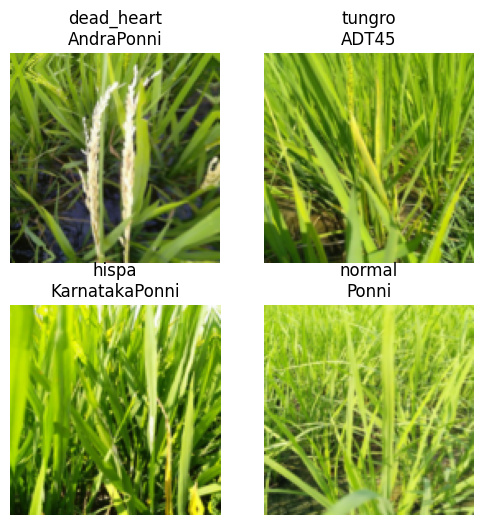

In [ ]:
dls.show_batch(max_n=4)

## 3. Creating the basic Disease model:

In [ ]:
def disease_err(inp, disease, variety):
  return error_rate(inp, disease)

def disease_loss(inp, disease, variety):
  return F.cross_entropy(inp, disease)

In [ ]:
arch = 'convnext_small_in22k'
learner = vision_learner(dls, arch, loss_func=disease_loss, metrics=disease_err, n_out=10).to_fp16()
lr=0.01


Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_small_22k_224.pth" to /root/.cache/torch/hub/checkpoints/convnext_small_22k_224.pth


In [ ]:
learner.fine_tune(10, lr)

epoch,train_loss,valid_loss,disease_err,time
0,1.233209,0.715346,0.233061,01:19


epoch,train_loss,valid_loss,disease_err,time
0,0.594134,0.393805,0.126862,01:27
1,0.462260,0.379326,0.122057,01:24
2,0.373016,0.343372,0.109563,01:24
3,0.317029,0.267491,0.069678,01:29
4,0.224575,0.180753,0.053340,01:24
5,0.175142,0.151156,0.042768,01:26
6,0.112938,0.125925,0.037482,01:23
7,0.082557,0.105246,0.028832,01:24
8,0.058609,0.099328,0.028352,01:26
9,0.049635,0.096824,0.028352,01:28


## 4. Multi-Target Model:

In [ ]:
learner = vision_learner(dls, arch, n_out=20).to_fp16()

In [ ]:
#Defining Loss function for: Disease & Variety

def disease_loss(inp, disease, variety):
  return F.cross_entropy(inp[:, :10], disease)

def variety_loss(inp, disease, variety):
  return F.cross_entropy(inp[:, 10:], variety)

# Combining the outputs of the two loss functions
def combine_loss(inp, disease, variety):
  return disease_loss(inp, disease, variety) + variety_loss(inp, disease, variety)


In [ ]:
#Defining error_rate function for: Disease & Variety

def disease_err(inp, disease, variety):
  return error_rate(inp[:, :10], disease)

def variety_err(inp, disease, variety):
  return error_rate(inp[:, 10:], variety)

error_metrics = (disease_err, variety_err)
all_metrics = error_metrics + (disease_loss, variety_loss)


In [ ]:
#Creating the multi-target model

model = vision_learner(dls, arch, loss_func=combine_loss, metrics=all_metrics, n_out=20).to_fp16()

In [ ]:
model.fine_tune(12, lr)

epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,2.209568,1.204050,0.272465,0.126862,0.817150,0.386899,01:20


epoch,train_loss,valid_loss,disease_err,variety_err,disease_loss,variety_loss,time
0,1.010258,0.588426,0.136473,0.049976,0.416766,0.171660,01:24
1,0.738181,0.482422,0.112446,0.042287,0.349922,0.132501,01:24
2,0.607621,0.417155,0.092744,0.030274,0.312128,0.105027,01:23
3,0.515450,0.358166,0.085536,0.025469,0.268395,0.089771,01:26
4,0.394507,0.235002,0.059106,0.013936,0.186508,0.048494,01:24
5,0.283316,0.219805,0.047093,0.013936,0.166774,0.053032,01:27
6,0.235300,0.167700,0.044210,0.009130,0.130431,0.037269,01:28
7,0.178849,0.180370,0.041326,0.008650,0.148650,0.031720,01:28
8,0.115506,0.148788,0.036521,0.007208,0.121869,0.026919,01:24
9,0.097843,0.135023,0.030274,0.006728,0.109620,0.025403,01:26
